In [1]:
%matplotlib widget
from ipywidgets import interact
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os,glob, socket
import tifffile as tif
import sympy as sp
import pickle
import time

In [2]:
def veloc_tunel(V):
    tunel_v = pd.read_csv('tunel_viento.csv',header=None)
    deltaV, U = tunel_v.to_numpy().T
    p1 = np.polyfit(deltaV,U,1)
    UdeltaV = np.poly1d(p1)
    return UdeltaV(V)
    
class camfast:
    def __init__(self,name):
        self.dir = name
        datafile = name.split('_')
        D = 50e-2
        self.th = float(datafile[1].replace('t',''))*1e-6
        self.L = float(datafile[2].replace('L',''))/100*D
        g = 9.8
        if self.th == 75e-6:
            self.rho = 1300
            self.y1 = 37.3e-3
        elif self.th == 50e-6:
            self.rho = 1900
            self.y1 = 50.2e-3
        else:
            self.th = 10000
            self.rho = 1900
            self.y1 = 0.01


        self.B =  ((self.y1*1.103)**3)*self.rho*self.th*g # rigidez a la flexion por unidad de longitud
        self.I = (self.th)**3/12  #momento de inercia por unidad de longitud
        self.E = self.B / self.I

        self.coords = 0
        self.IM_vec0 = 0
        self.IM_vec1 = 0
        self.IM_mean = 0
        self.IM_std = 0
        self.FFT_VEC0 = 0
        self.FFT_VEC1 = 0
        self.FFT_fps = 250
        self.FFT_freqs = 0


        


    

In [3]:
def plot(nfile,dir_i):
    if dir_i.split('_')[4]=='1':
        namefile = 'output_fastcam/'+''.join(dir_i.split('_')[1:4])+'_1.csv'
    else:        
        namefile = 'output_fastcam/'+''.join(dir_i.split('_')[1:4])+'_0.csv'
        
    plt.close('all')
    print(namefile)
    if os.path.isfile(namefile)==False:
        fig,ax = plt.subplots()
        file_list = np.sort(glob.glob(dir_w+dir_i+'/*.tif'))
        if nfile>len(file_list):
            nfile = len(file_list)-1
        im_ref = tif.imread(file_list[nfile])
        ax.imshow(im_ref)
        n,m = im_ref.shape
        ax.text(int(4*m/5),(n/2),f'snapshot={nfile:01n}',color='w')
        ax.set_xlim([0,int(m/2)])
        ax.set_ylim([int(n/2),n])
        x0 = plt.ginput(-1,timeout=0)
        
        print(x0)
        ax.set_xlim([int(m/2),m])
        ax.set_ylim([int(n/2),n])
        x1 = plt.ginput(-1,timeout=0) 
        print(x1)
        ax.set_xlim([0,int(m/2)])
        ax.set_ylim([0,int(n/2)])
        x2 = plt.ginput(-1,timeout=0) 
        print(x2)
        ax.set_xlim([m,int(m/2)])
        ax.set_ylim([0,int(n/2)])
        x3 = plt.ginput(-1,timeout=0) 
        print(x3)    
        print(dir_i)
        x = np.vstack((x0,x1,x2,x3))
        A = pd.DataFrame(data=x,index=['x0','x1','x2','x3'])
    
        A.to_csv(namefile)
        
        return x


In [4]:
if socket.gethostname() =='pc-i7':
    dir_w = '/mnt/sdb4/juan/data_2024/photron/'    
else:
    dir_w = '/media/juan/JUAN_PMMH/LFD/photron/'
dirlist = np.sort(os.listdir(dir_w))
dir_i = dirlist[-10]

In [5]:
matching_t075 = [s for s in dirlist if "t075" in s]


In [6]:
import scipy as sc
import sympy as sp
x, y, z = sp.symbols('x y z')
eq1 = sp.diff(sp.cos(x)*sp.cosh(x)+1, x)
def fun_modn (x):
    return np.cosh(x)*np.cos(x)+1
    
callable_fct = sp.lambdify(x, eq1)

In [7]:
x_s = np.linspace(1,15,200)
y_s = np.zeros_like(x_s)
for i,xi in enumerate(x_s):
    y_s[i] = fun_modn(xi)
signo_s = np.sign(y_s)
diff_signo_s = np.diff(signo_s)
x0s = x_s[np.nonzero(diff_signo_s)]

In [8]:
BnL = np.zeros_like(x0s)
for i,x0i in enumerate(x0s):
    BnL[i] = sc.optimize.fsolve(fun_modn,x0i,fprime=callable_fct)[0]
#BnL = np.unique(A.round(decimals=4))

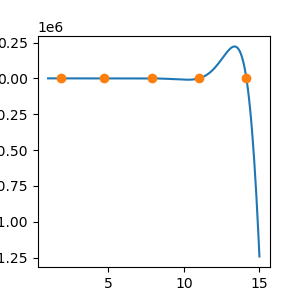

In [9]:
fig,ax = plt.subplots(figsize=(3,3))
ax.plot(x_s,y_s)
ax.plot(BnL,fun_modn(BnL),marker='o',linestyle='none')


In [10]:
BnL

array([ 1.87510407,  4.69409113,  7.85475744, 10.99554073, 14.13716839])

In [11]:
#collect data from images

dirout = 'fastcam_objs/'
lista_casos = np.sort(glob.glob('output_fastcam/*.csv'))

In [ ]:
time0= time.time()
for i, casoi in enumerate(lista_casos[:]):
    print(casoi)
    print(time.time()-time0)
    A = pd.read_csv(casoi,index_col=0).to_numpy()
    thickn = casoi.split('/')[-1].split('t')[-1][:3]
    Length = casoi.split('/')[-1].split('L')[-1][:3]
    Veloc = casoi.split('/')[-1].split('v')[1][:2].split('_')[0]
    name =  't'+thickn+'_L'+Length+'_v'+Veloc
    matching = [s for s in dirlist if name in s]
    for file_im in matching[:]:
        caso = camfast(file_im)
        nameout = dirout+caso.dir+'.pickle'
        if os.path.isfile(nameout)==False:
            print('Serie '+caso.dir  )
            lista_imgs = np.sort(glob.glob(dir_w+file_im+'/*.tif'))
            x0a = A[np.argsort(A[:,0])[:2]]
            x0b = A[np.argsort(A[:,0])[2:]]
            x1,x2 = x0a[np.argsort(x0a[:,1])[:2]]
            x3,x4 = x0b[np.argsort(x0b[:,1])[:2]]
            caso.coords = [x1,x2,x3,x4]
            Nfiles = len(lista_imgs)
            ncolumn = 30
            vec_0, vec_1 = np.zeros((2,Nfiles,2*ncolumn))
            nxmin = int(np.min((x1[0],x2[0])))
            nxmax = int(np.max((x3[0],x4[0])))
            nfile = np.abs(nxmax-nxmin)
            #IM0,IM1 = np.zeros((2,Nfiles,2*ncolumn,nfile))
            for i, filei in enumerate(lista_imgs[:]):
                IM = tif.imread(filei)
                if i==0:
                    IM_m = IM
                else:
                    IM_m += IM
                #IM0[i] = IM [int(x1[1])-ncolumn:int(x1[1])+ncolumn,nxmin:nxmin+nfile]
                vec_0[i] = IM [int(x1[1])-ncolumn:int(x1[1])+ncolumn,int(x1[0])]
                vec_1[i] = IM [int(x2[1])-ncolumn:int(x2[1])+ncolumn,int(x2[0])]
            caso.IM_vec0 = vec_0
            caso.IM_vec1 = vec_1
            caso.IM_mean = IM_m
            VEC_0 = np.fft.fft(vec_0-vec_0.mean(0),axis=0)
            VEC_1 = np.fft.fft(vec_1-vec_1.mean(0),axis=0)
            freqs = np.fft.fftfreq(len(vec_0),1/250)
            caso.FFT_VEC0= VEC_0
            caso.FFT_VEC1= VEC_1
            caso.FFT_freqs = freqs
            
            nameout = dirout+caso.dir+'.pickle'
            with open(nameout, 'wb') as handle:
                pickle.dump(caso, handle, protocol=pickle.HIGHEST_PROTOCOL)
            print(f'tiempo {time.time()-time0:.1f}seg.')
        else:
            print('Caso guardado')
    




In [ ]:
caso.dir

In [ ]:
time0 = time.time()


In [ ]:
fig,ax = plt.subplots(figsize=(5,3))
ax.contour(caso.IM_vec0.T,colors='k')

In [ ]:
fig,ax = plt.subplots()
ax.contourf(caso.IM_mean.T)

In [ ]:
plt.subplots()
ax.imshow(IM0[0].T)

In [ ]:
fig0,ax0 = plt.subplots(figsize=(5,2))
ax0.contourf(vec_2.T,cmap='binary')


ax0.set_xlabel('$N_{image}$')
ax0.set_ylabel('pixels')  
ax0.set_xlabel('$N_{image}$');
ax0.grid()

In [ ]:
casoi

In [ ]:
B = tif.imread(lista_imgs[0])
fig,ax = plt.subplots()
ax.imshow(B)
for i,Ai in enumerate(A):
    ax.plot(Ai[0],Ai[1],'wo',markersize=(i+1)*2)

Nfiles = 2000
ncolumn = 20
vec_1, vec_2 = np.zeros((2,Nfiles,2*ncolumn))
for i, filei in enumerate(file_list[:Nfiles]):
    A = tif.imread(filei)
    vec_1[i] = A [y1-ncolumn:y1+ncolumn,x1]
    vec_2[i] = A [y2-ncolumn:y2+ncolumn,x2]
    


In [ ]:
matching = [s for s in dirlist if name in s]

In [ ]:
matching

In [ ]:
casoi.split('/')[-1][:-4]

In [ ]:
dirlist